In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
import sklearn
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score

In [3]:
from scipy.stats import pearsonr

In [4]:
%store -r df_Xy

In [5]:
df_Xy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3032 entries, 2008-09-05 to 2020-05-27
Columns: 363 entries, gbp_rate to gold_dif_lag10
dtypes: float64(363)
memory usage: 8.4 MB


# We want to investigate the predictivty of central bank policy rates and stock market index performance as they relate to the price of gold. 
## We'll attempt to use time series modeling to predict the daily price, daily price difference, and daily percent change in price of gold.
### We have the most recent 10 years of daily data from the following sources:
### Features:
#### Top 5 equity market indices by market capitalization, per Statista: https://www.statista.com/statistics/270126/largest-stock-exchange-operators-by-market-capitalization-of-listed-companies/, and their corresponding daily performance and percent change
NYSE Composite Index history: https://finance.yahoo.com/quote/%5ENYA?p=^NYA&.tsrc=fin-srch
NASDAQ Composite Index history: https://finance.yahoo.com/quote/%5EIXIC?p=^IXIC&.tsrc=fin-srch
Japan Exchange Group Composite Index history: https://finance.yahoo.com/quote/8697.T?p=8697.T&.tsrc=fin-srch
Shanghai Stock Exchange Composite Index history: https://finance.yahoo.com/quote/%5ESSEC?p=^SSEC&.tsrc=fin-srch
Hang Seng (Hong Kong) Index History: https://finance.yahoo.com/quote/%5EHSI?p=^HSI&.tsrc=fin-srch
#### Top 5 Currencies Globally in Forex Trading (https://www.ig.com/us/trading-strategies/top-10-most-traded-currency-pairs-191206), and their corresponding daily central bank policy rates and percent change
The Fed (USD): https://fred.stlouisfed.org/series/FEDFUNDS
ECB (EUR): https://www.ecb.europa.eu/stats/policy_and_exchange_rates/key_ecb_interest_rates/html/index.en.html
BoJ (JPY): https://fred.stlouisfed.org/series/IRSTCI01JPM156N
United Kingdom (GBP): https://fred.stlouisfed.org/series/GBPONTD156N
Australia (AUD): https://www.rba.gov.au/statistics/cash-rate/
#### Daily price of gold  and percent change (up to 10-day lag): https://www.usagold.com/reference/prices/goldhistory.php



### Targets:
#### Daily price of gold, daily percent change price of gold: https://www.usagold.com/reference/prices/goldhistory.php

## As the data sits, we currently have both daily policy rates and index scores - each with up to a ten day lag as the data. This translates to 242 features in our would-be model.

### For sake of dimensionality reduction, let's first get just the raw values into one data frame, and the percent change values into another. It will be interesting to see if gold's price or gold's percent price change is 'easier' to predict. 

In [6]:
# store column titles to create separate dataframes for raw values, differences, and percent changes

col_raw = []
col_dif = []
col_change = []

for col in df_Xy.columns:
    if 'change%' in col:
        col_change.append(col)
    elif 'dif' in col:
        col_dif.append(col)
    else:
        col_raw.append(col)

In [7]:
# create three separate dataframes, one with raw values, one with differences, and one with percent change

df_Xy_raw = df_Xy[col_raw].dropna()

df_Xy_dif = df_Xy[col_dif].dropna()

df_Xy_change = df_Xy[col_change].dropna()

In [8]:
df_Xy_raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3022 entries, 2008-09-19 to 2020-05-27
Columns: 121 entries, gbp_rate to gold_lag10
dtypes: float64(121)
memory usage: 2.8 MB


In [9]:
df_Xy_dif.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3021 entries, 2008-09-22 to 2020-05-27
Columns: 121 entries, gbp_rate_dif to gold_dif_lag10
dtypes: float64(121)
memory usage: 2.8 MB


In [10]:
df_Xy_change.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3032 entries, 2008-09-05 to 2020-05-27
Columns: 121 entries, gbp_rate_change% to gold_change%_lag10
dtypes: float64(121)
memory usage: 2.8 MB


#### To compare models on a level playing field, we need to ensure the same date range is being used for both the raw and the change data. Let's take a look at the date ranges in all of our datasets. It looks like our difference dataframe is the limiting factor here with '2008-09-22' being the earliest date in the dataset.

In [11]:
df_Xy_raw = df_Xy_raw[df_Xy_raw.index >= '2008-09-22']
df_Xy_raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3021 entries, 2008-09-22 to 2020-05-27
Columns: 121 entries, gbp_rate to gold_lag10
dtypes: float64(121)
memory usage: 2.8 MB


In [12]:
df_Xy_change = df_Xy_change[df_Xy_change.index >= '2008-09-22']
df_Xy_change.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3021 entries, 2008-09-22 to 2020-05-27
Columns: 121 entries, gbp_rate_change% to gold_change%_lag10
dtypes: float64(121)
memory usage: 2.8 MB


In [13]:
# create X,y pairs for both raw and percent change dataframes

X_raw = df_Xy_raw.drop(columns = ['gold'])
y_raw = df_Xy_raw['gold']

X_dif = df_Xy_dif.drop(columns = ['gold_dif'])
y_dif = df_Xy_dif['gold_dif']

X_change = df_Xy_change.drop(columns = ['gold_change%'])
y_change = df_Xy_change['gold_change%']

## EDA
### Historical Gold Data Trends

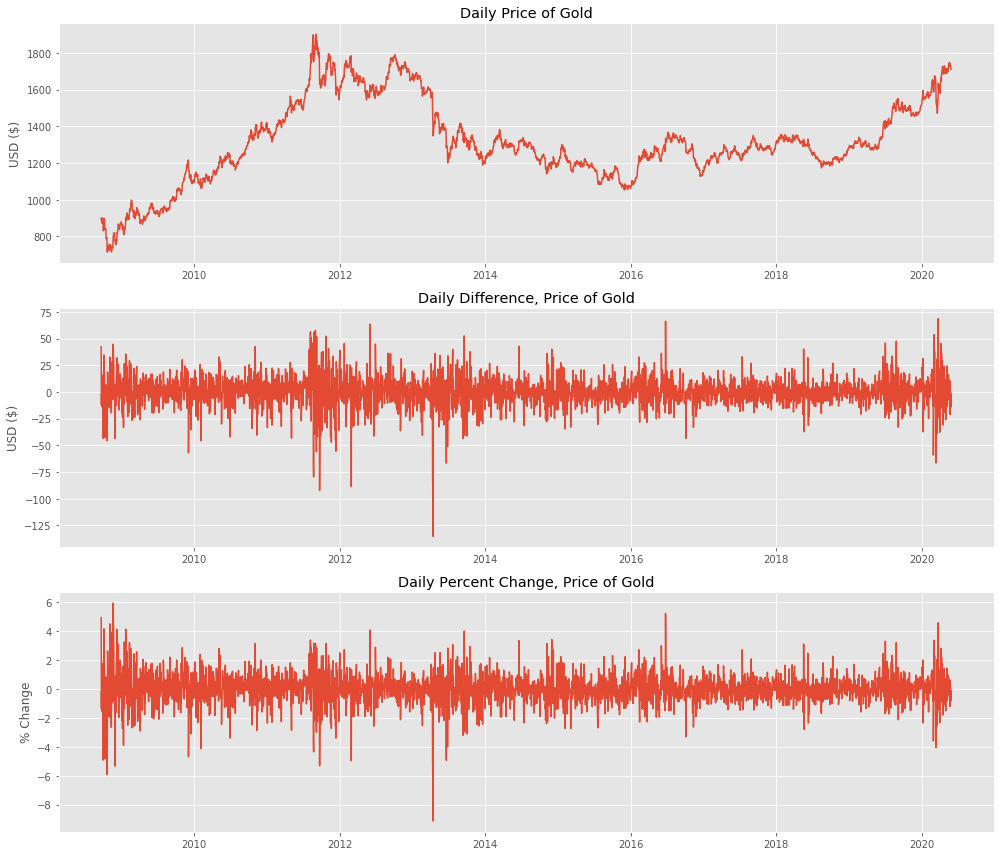

In [22]:
fig,axs = plt.subplots(3,1, figsize = (14,12))

for ax,metric,series in zip(axs,[('Daily Price of Gold','USD ($)'), ('Daily Difference, Price of Gold','USD ($)'),\
                            ('Daily Percent Change, Price of Gold','% Change')],[y_raw,y_dif,y_change]):
        ax.plot(series.index,series)
        ax.set_title(metric[0])
        ax.set_ylabel(metric[1])
plt.tight_layout()        